In [ ]:
import warnings
import pandas as pd
from pandas import concat
import numpy as np
from numpy import array
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


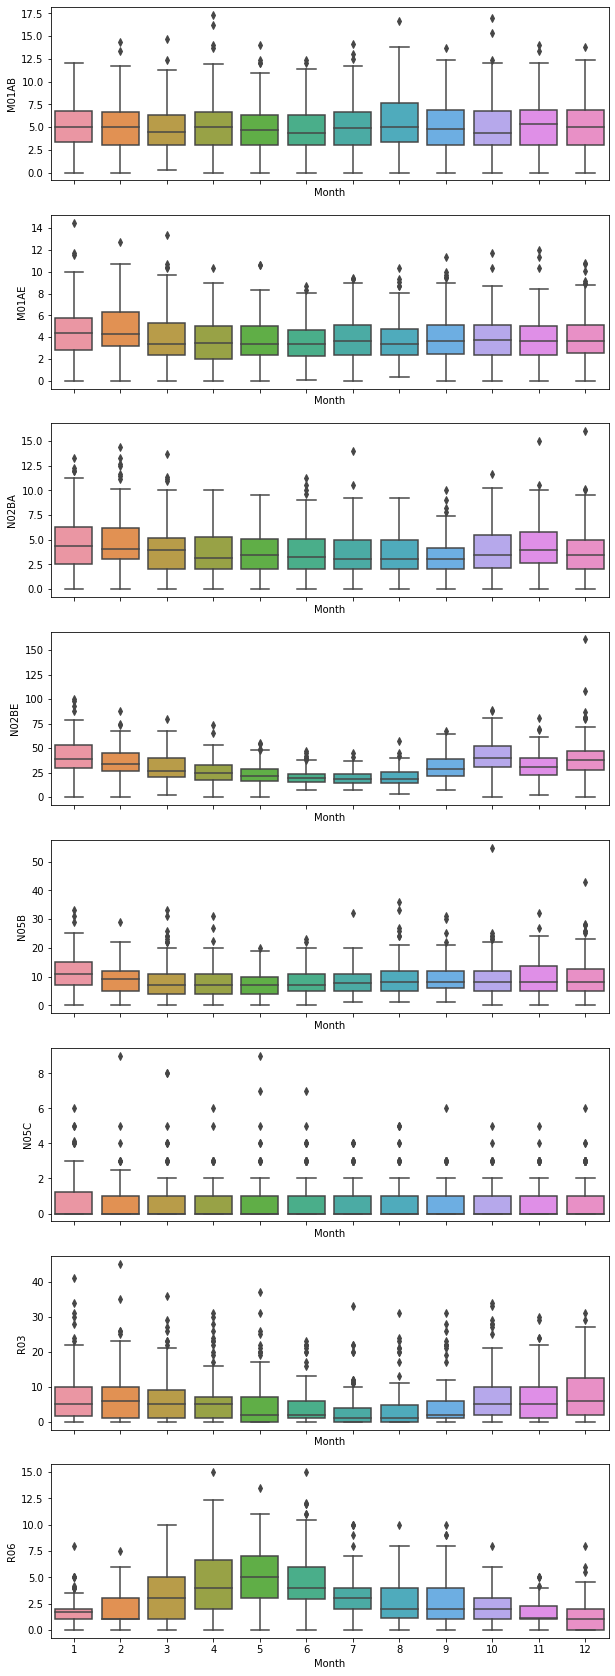

In [ ]:
import seaborn as sns
dfatc_daily = pd.read_csv('/content/salesdaily.csv')
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Month', y=name, ax=ax)

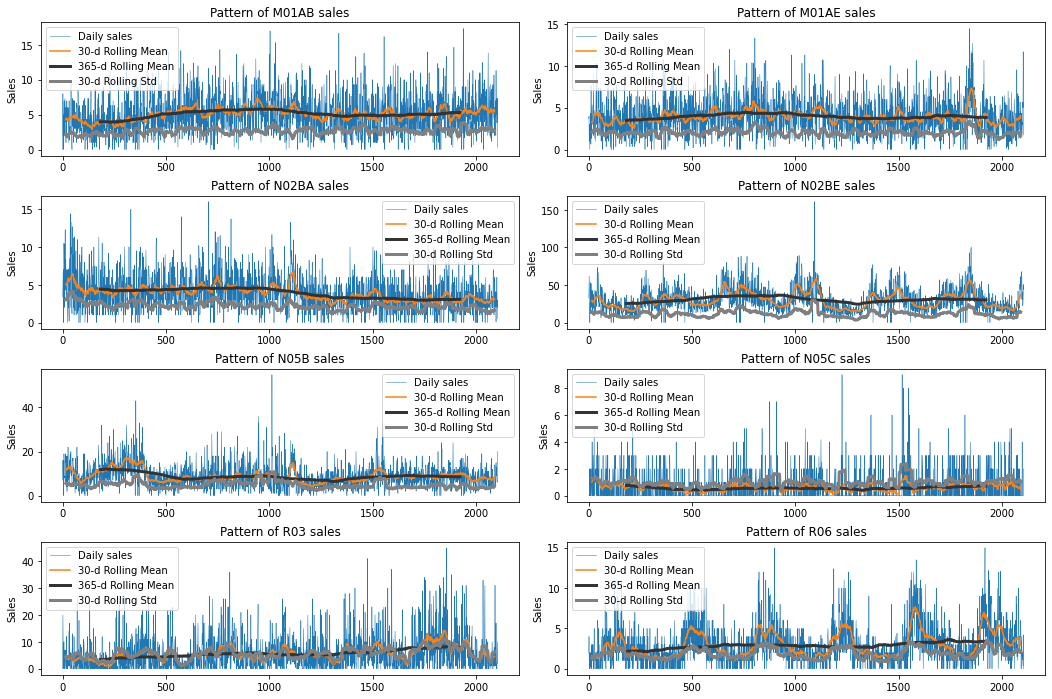

In [ ]:
dfatc_daily=pd.read_csv('/content/salesdaily.csv')
cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='Daily sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Pattern of '+x+' sales');   
    subplotindex=subplotindex+1
plt.show()

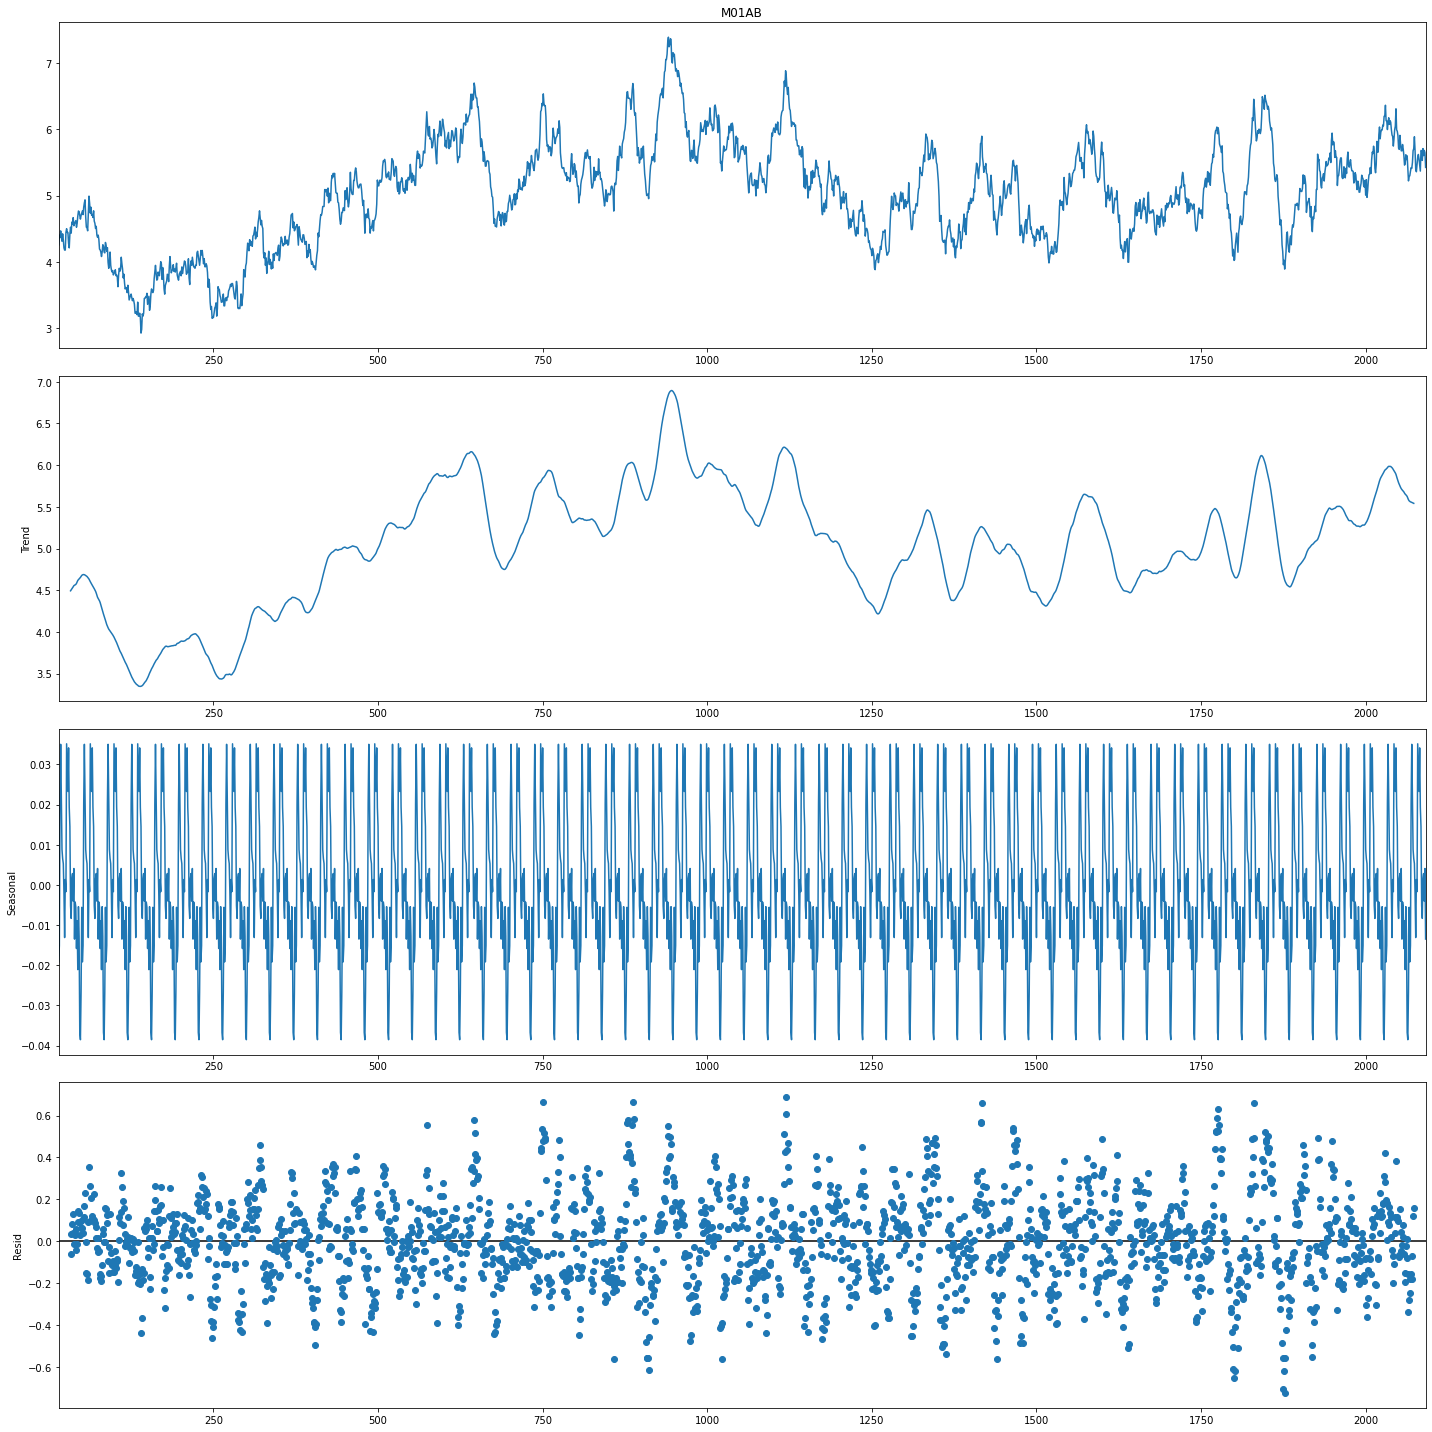

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dfatc_daily['M01AB'].rolling(30, center=True).mean().dropna(), period=36, filt=None)
plt.rcParams["figure.figsize"] = (20,20)
result.plot()
plt.show()

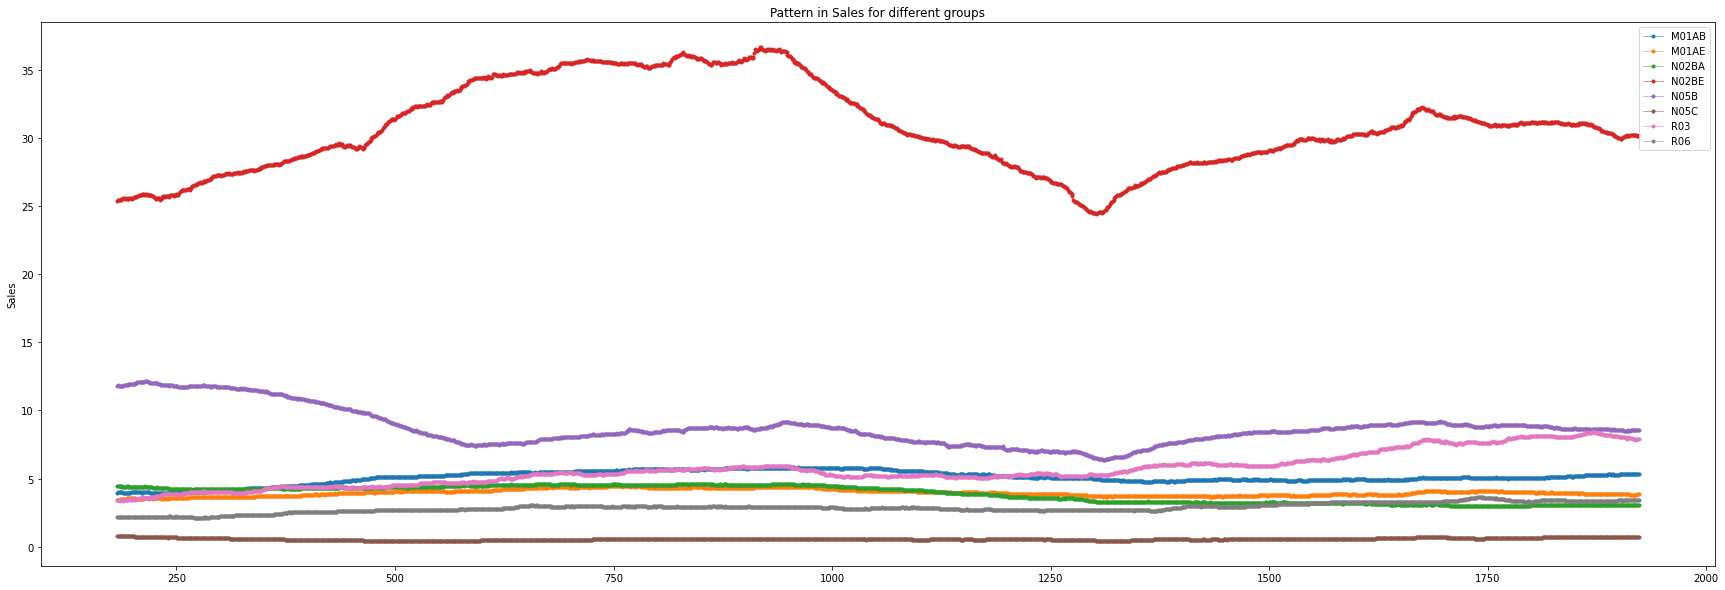

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
for nm in cols_plot:
    ax.plot(dfatc_365d[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Sales')
    ax.set_title('Pattern in Sales for different groups');

In [ ]:
df = pd.read_csv('/content/salesweekly.csv')
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    result = seasonal_decompose(df[x], period=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' Rmean:'+str(resmean)+', Omean:'+str(obsmean)+', Percentage:'+str(perc)+'%')

M01AB Rmean:5.26715996284115, Omean:35.59490833332001, Percentage:14.797509558159527%
M01AE Rmean:4.319542609675869, Omean:28.00801458336, Percentage:15.422523423856601%
N02BA Rmean:3.9228389592521657, Omean:27.083016, Percentage:14.484498178682042%
N02BE Rmean:29.534357236963668, Omean:217.6597028336, Percentage:13.569051529737028%
N05B Rmean:12.94840305932125, Omean:61.96614999972, Percentage:20.895929566997072%
N05C Rmean:2.0384606385595405, Omean:3.871833333332, Percentage:52.648460382081936%
R03 Rmean:11.722244335544508, Omean:40.06845833336, Percentage:29.25554119906046%
R06 Rmean:4.278758416393868, Omean:19.744589999960002, Percentage:21.67053565762842%


In [ ]:
df = pd.read_csv('/content/salesweekly.csv')    
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

M01AB: 1.141130089570642
M01AE: 1.166363924596575
N02BA: 1.1370638730125302
N02BE: 1.058024809082593
N05B: 1.074437415034502
N05C: 1.0361887401424648
R03: 1.1847216239035152
R06: 1.031759595747876


In [ ]:
df=pd.read_csv('/content/salesweekly.csv')
from statsmodels.tsa.stattools import adfuller

for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    dftest = adfuller(df[x], regression='ct', autolag='AIC')
    print(x)
    print("-----------------------------")
    print("Statistic = {:.3f}".format(dftest[0]))
    print("P = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

M01AB
-----------------------------
Statistic = -3.700
P = 0.022
Critical values :
	1%: -3.9897903649837616 - not stationary with 99% confidence
	5%: -3.425478311521626 -  stationary with 95% confidence
	10%: -3.1358607194990724 -  stationary with 90% confidence
M01AE
-----------------------------
Statistic = -8.717
P = 0.000
Critical values :
	1%: -3.98926783537037 -  stationary with 99% confidence
	5%: -3.425226747185185 -  stationary with 95% confidence
	10%: -3.1357131066666666 -  stationary with 90% confidence
N02BA
-----------------------------
Statistic = -2.670
P = 0.249
Critical values :
	1%: -3.990441532957606 - not stationary with 99% confidence
	5%: -3.425791763669738 - not stationary with 95% confidence
	10%: -3.1360446341572343 - not stationary with 90% confidence
N02BE
-----------------------------
Statistic = -4.362
P = 0.003
Critical values :
	1%: -3.98926783537037 -  stationary with 99% confidence
	5%: -3.425226747185185 -  stationary with 95% confidence
	10%: -3.1357

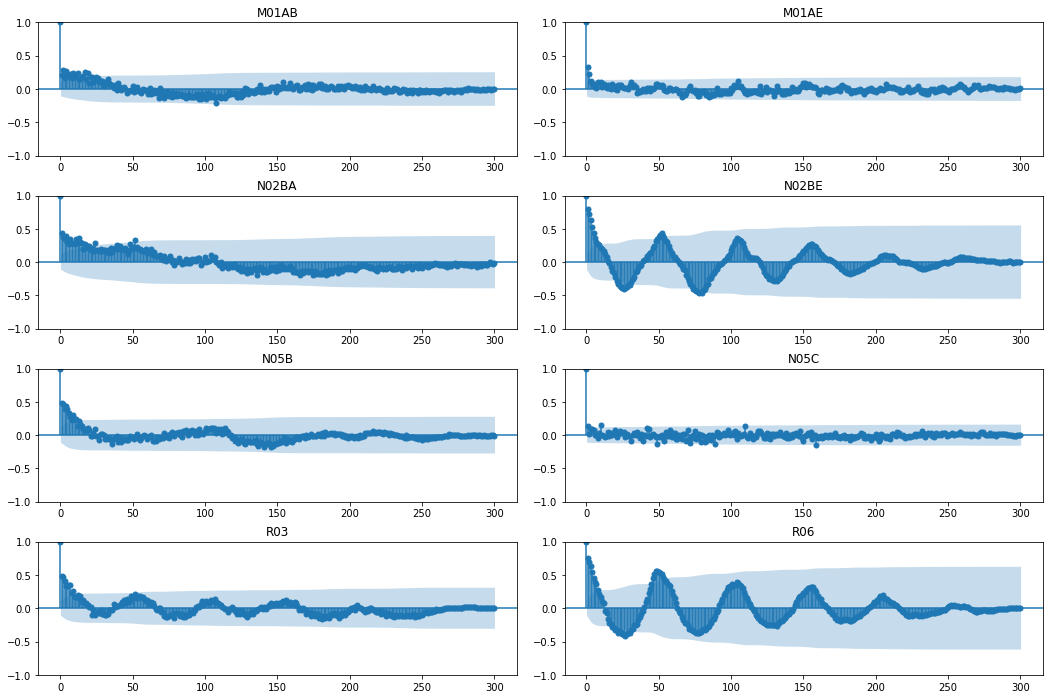

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,12))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_acf(df[x], lags=300, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

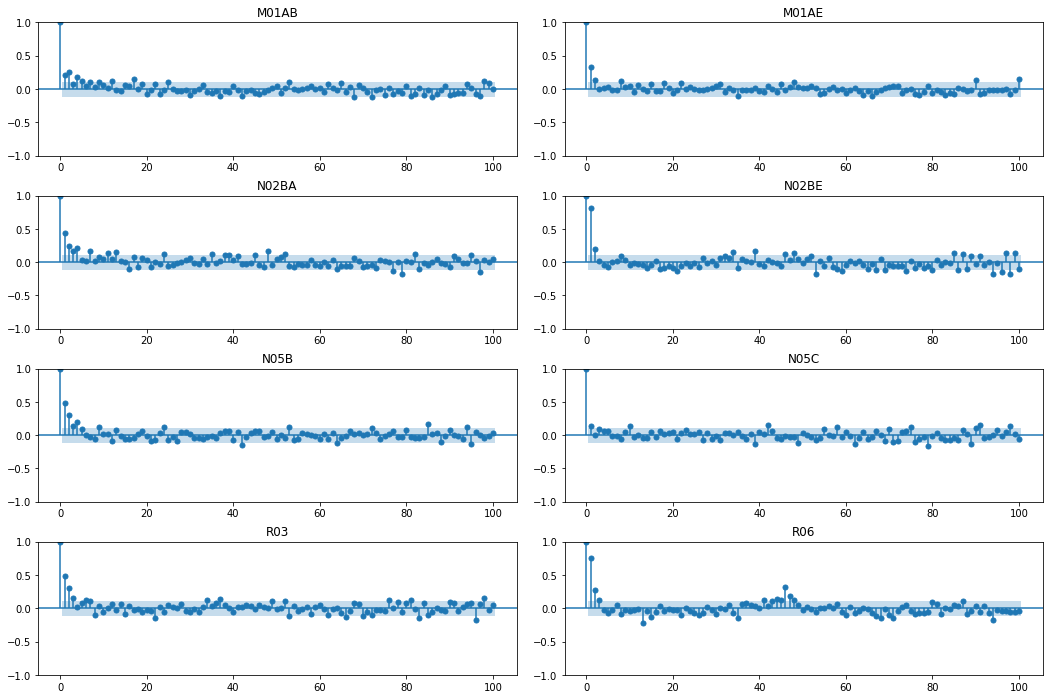

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=100, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

In [ ]:
resultsRolling={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsRollingdf = pd.DataFrame(resultsRolling)
resultsRollingdf.index = ['Naive MSE', 'Naive MAPE', 'Seasonal Naive MSE', 'Seasonal Naive MAPE', 
                          'ARIMA MSE', 'ARIMA MAPE', 'AutoARIMA MSE', 'AutoARIMA MAPE',
                         'Prophet MSE', 'Prophet MAPE']
resultsLongterm={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsLongtermdf = pd.DataFrame(resultsLongterm)
resultsLongtermdf.index = ['Average MSE', 'Average MAPE', 'ARIMA MSE', 'ARIMA MAPE', 
                           'AutoARIMA MSE', 'AutoARIMA MAPE', 'Prophet MSE', 'Prophet MAPE',
                          'Vanilla LSTM MSE', 'Vanilla LSTM MAPE', 'Stacked LSTM MSE', 'Stacked LSTM MAPE',
                          'Bidirectional LSTM MSE', 'Bidirectional LSTM MAPE']

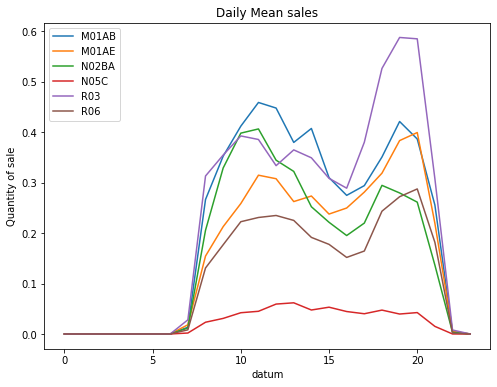

In [ ]:
dfatch=pd.read_csv('/content/saleshourly.csv')
dfatch['datum']= pd.to_datetime(dfatch['datum']) 

grp1=dfatch.groupby(dfatch.datum.dt.hour)['M01AB'].mean()
grp2=dfatch.groupby(dfatch.datum.dt.hour)['M01AE'].mean()
grp3=dfatch.groupby(dfatch.datum.dt.hour)['N02BA'].mean()
grp6=dfatch.groupby(dfatch.datum.dt.hour)['N05C'].mean()
grp7=dfatch.groupby(dfatch.datum.dt.hour)['R03'].mean()
grp8=dfatch.groupby(dfatch.datum.dt.hour)['R06'].mean()

plt.title('Daily Mean sales')
plt.xlabel('Time of day')
plt.ylabel('Quantity of sale')
grp1.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06'], loc='upper left')

plt.show()

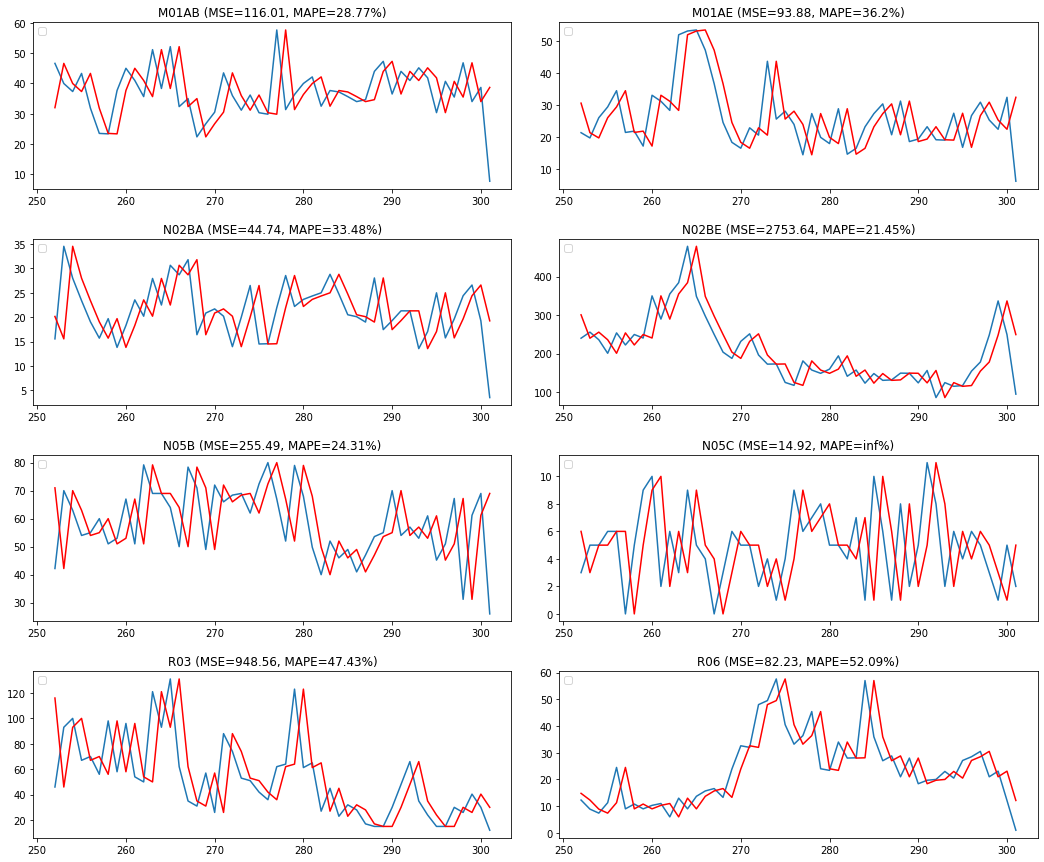

In [ ]:
df=pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ds=df[x]
    dataframe = concat([ds.shift(1), ds], axis=1)
    dataframe.columns = ['t+1', 't-1']
    size = len(dataframe)-50
    X=dataframe['t-1']
    Y=dataframe['t+1']
    test, predictions = X[size:len(X)], Y[size:len(Y)]
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Naive MSE',x]=error
    resultsRollingdf.loc['Naive MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

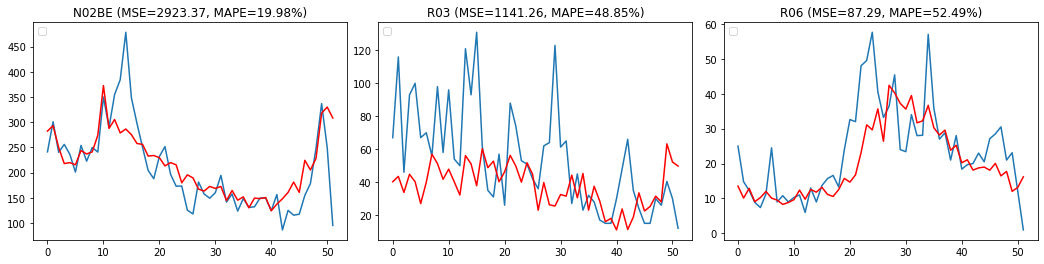

In [ ]:
df=pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=1
numcols=3
fig, ax = plt.subplots(numrows, numcols, figsize=(18,4))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['N02BE','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-52
    test = X[size:len(X)]
    train = X[0:size]
    predictions=list()
    history = [x for x in train]
    for i in range(len(test)):
        obs=list()
        for y in range(1,5):
            obs.append(train[-(y*52)+i])
        yhat = np.mean(obs)
        predictions.append(yhat)
        history.append(test[i])
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Seasonal Naive MSE',x]=error
    resultsRollingdf.loc['Seasonal Naive MAPE',x]=perror
    ax[colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[colindex].plot(test)
    ax[colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show() 

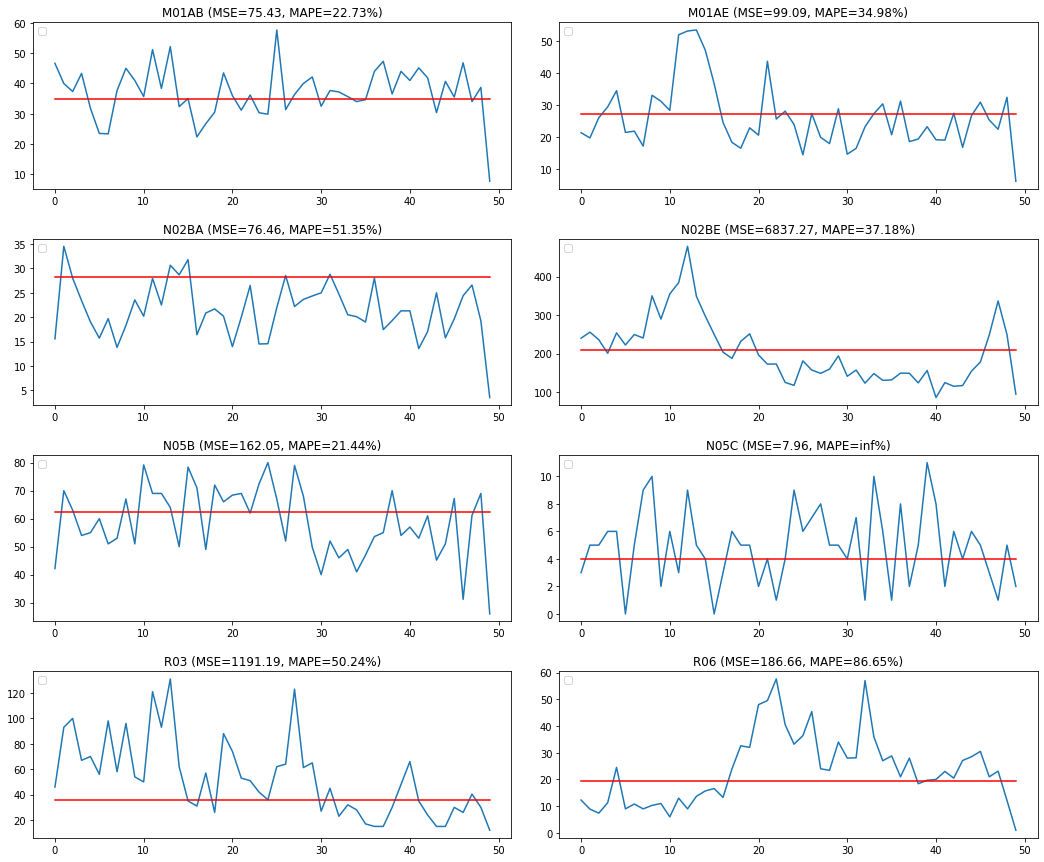

In [ ]:
df=pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-50
    test = X[size:len(X)] 
    mean = np.mean(X[0:size])
    predictions = np.full(50,mean)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['Average MSE',x]=error
    resultsLongtermdf.loc['Average MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

In [ ]:
import statsmodels.api as sm
df=pd.read_csv('/content/salesweekly.csv')
warnings.filterwarnings("ignore")
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    resDiff = sm.tsa.arma_order_select_ic(df[x], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q,'+x+') =',resDiff['aic_min_order'],'is suitable.')

ARMA(p,q,M01AB) = (3, 3) is suitable.
ARMA(p,q,M01AE) = (2, 0) is suitable.
ARMA(p,q,N02BA) = (3, 3) is suitable.
ARMA(p,q,N02BE) = (2, 2) is suitable.
ARMA(p,q,N05B) = (4, 3) is suitable.
ARMA(p,q,N05C) = (3, 2) is suitable.
ARMA(p,q,R03) = (1, 1) is suitable.
ARMA(p,q,R06) = (2, 2) is suitable.


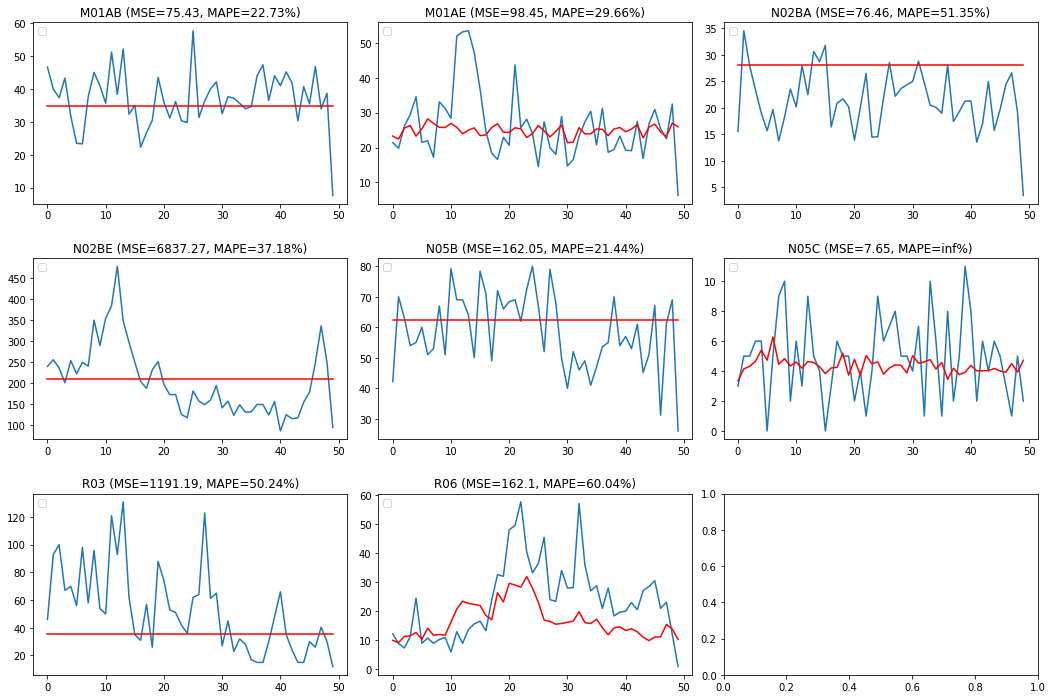

In [ ]:
df=pd.read_csv('/content/salesweekly.csv')
import statsmodels.api as sm
M01AB= {'series':'M01AB','p':0,'d':0,'q':0}
M01AE= {'series':'M01AE','p':4,'d':0,'q':4}
N02BA= {'series':'N02BA','p':0,'d':0,'q':0}
N02BE= {'series':'N02BE','p':0,'d':0,'q':0}
N05B= {'series':'N05B','p':0,'d':0,'q':0}
N05C= {'series':'N05C','p':2,'d':0,'q':2}
R03= {'series':'R03','p':0,'d':0,'q':0}
R06= {'series':'R06','p':2,'d':0,'q':2}

subplotindex=0
numrows=3
numcols=3
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for x in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = int(len(X) - 50)
    train, test = X[0:size], X[size:len(X)]
    model = sm.tsa.arima.ARIMA(train, order=(x['p'],x['d'],x['q']))
    model_fit = model.fit()
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    perror = mean_absolute_percentage_error(test, forecast)
    resultsLongtermdf.loc['ARIMA MSE',x['series']]=error
    resultsLongtermdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(forecast, color='red')
    subplotindex=subplotindex+1
plt.show()

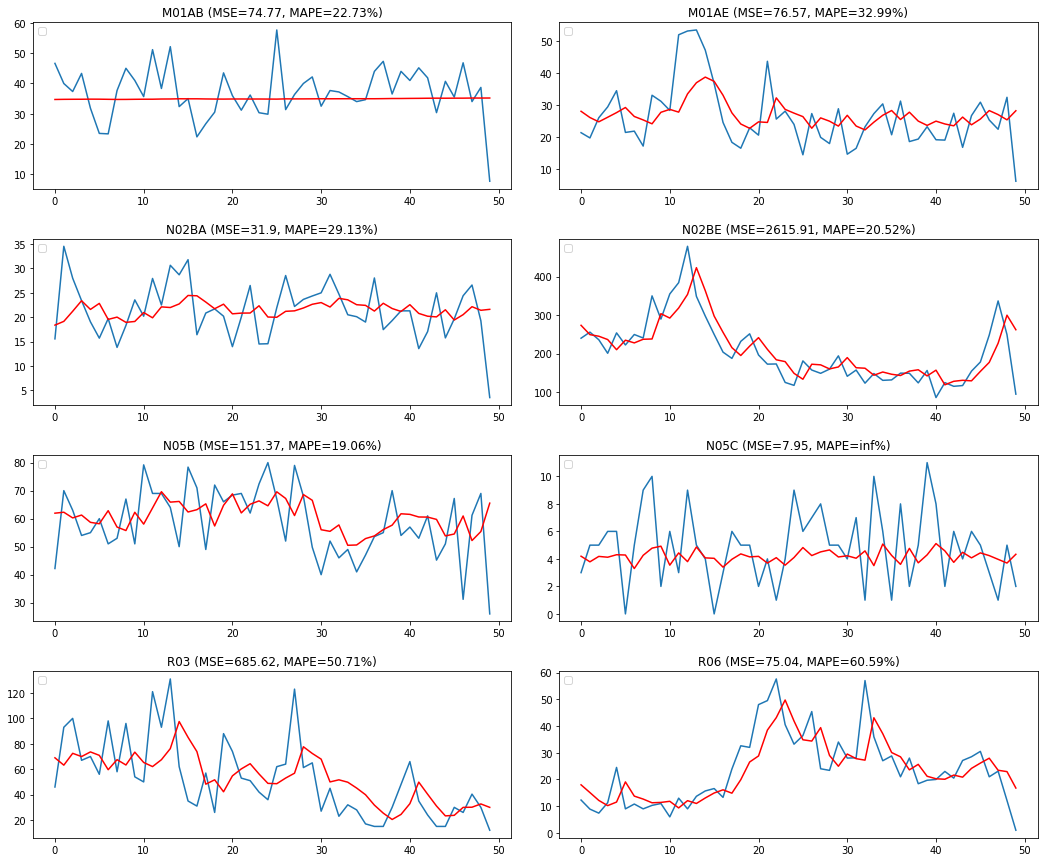

In [ ]:
df=pd.read_csv('/content/salesweekly.csv')
import statsmodels.api as sm
M01AB= {'series':'M01AB','p':0,'d':0,'q':0}
M01AE= {'series':'M01AE','p':2,'d':0,'q':0}
N02BA= {'series':'N02BA','p':5,'d':1,'q':1}
N02BE= {'series':'N02BE','p':2,'d':0,'q':0}
N05B= {'series':'N05B','p':0,'d':0,'q':5}
N05C= {'series':'N05C','p':0,'d':0,'q':1}
R03= {'series':'R03','p':5,'d':1,'q':1}
R06= {'series':'R06','p':1,'d':0,'q':1}

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for x in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.arima.ARIMA(history, order=(x['p'],x['d'],x['q']))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['ARIMA MSE',x['series']]=error
    resultsRollingdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

In [ ]:

!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 KB 2.5 MB/s eta 0:00:00
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [ ]:
import prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/8notmzkr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/_s_8yqvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31084', 'data', 'file=/tmp/tmpd0ewsj7j/8notmzkr.json', 'init=/tmp/tmpd0ewsj7j/_s_8yqvx.json', 'output', 'file=/tmp/tmpd0ewsj7j/prophet_modeldesey9qa/prophet_model-20230225094258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:42:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:42:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/_9a9q3ak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/fj1i787y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

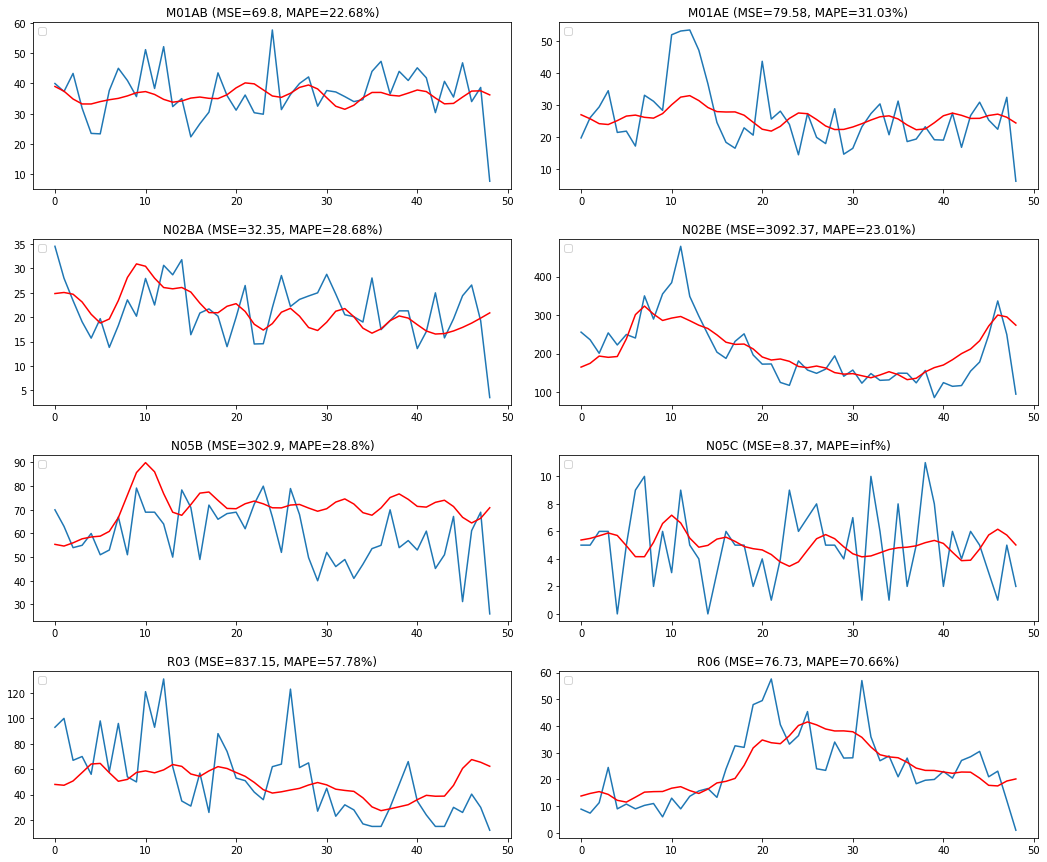

In [ ]:
df=pd.read_csv('/content/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

M01AB= {'series':'M01AB','params_grid':{'changepoint_prior_scale':30,'interval_width':0.0005}}
M01AE= {'series':'M01AE','params_grid':{'changepoint_prior_scale':0.05,'interval_width':0.0005}}
N02BA= {'series':'N02BA','params_grid':{'changepoint_prior_scale':0.005,'interval_width':0.0005}}
N02BE= {'series':'N02BE','params_grid':{'changepoint_prior_scale':10,'seasonality_prior_scale':170,'interval_width':0.0005}}
N05B= {'series':'N05B','params_grid':{'changepoint_prior_scale':5,'interval_width':0.0005}}
N05C= {'series':'N05C','params_grid':{'changepoint_prior_scale':0.5,'interval_width':0.005}}
R03= {'series':'R03','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':160,'interval_width':0.0005}}
R06= {'series':'R06','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':120,'interval_width':0.0005}}

r=[M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = int(len(dfg) - 50)
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    predictions = list()
    model = prophet.Prophet(changepoint_prior_scale=x['params_grid']['changepoint_prior_scale'],
                              growth='linear', interval_width=x['params_grid']['interval_width'], 
                              daily_seasonality=False, 
                              weekly_seasonality=False
                           )
    if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
        model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                prior_scale=x['params_grid']['seasonality_prior_scale'],
                                fourier_order=13)
    model_fit = model.fit(dfgtrain)
    future = model.make_future_dataframe(periods=50, freq='W')
    output = model.predict(future)
    predictions=output.loc[size+2:len(dfg),:]['yhat'].values
    
    error = mean_squared_error(dfgtest['y'].values, predictions)
    perror = mean_absolute_percentage_error(dfgtest['y'].values, predictions)
    resultsLongtermdf.loc['Prophet MSE',x['series']]=error
    resultsLongtermdf.loc['Prophet MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(dfgtest['y'].values)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/6g7orxqn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/1kv5r9cz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79161', 'data', 'file=/tmp/tmpd0ewsj7j/6g7orxqn.json', 'init=/tmp/tmpd0ewsj7j/1kv5r9cz.json', 'output', 'file=/tmp/tmpd0ewsj7j/prophet_model08cr1u4t/prophet_model-20230225093543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:35:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:35:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/2oy4ghpw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/hsggu1c6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

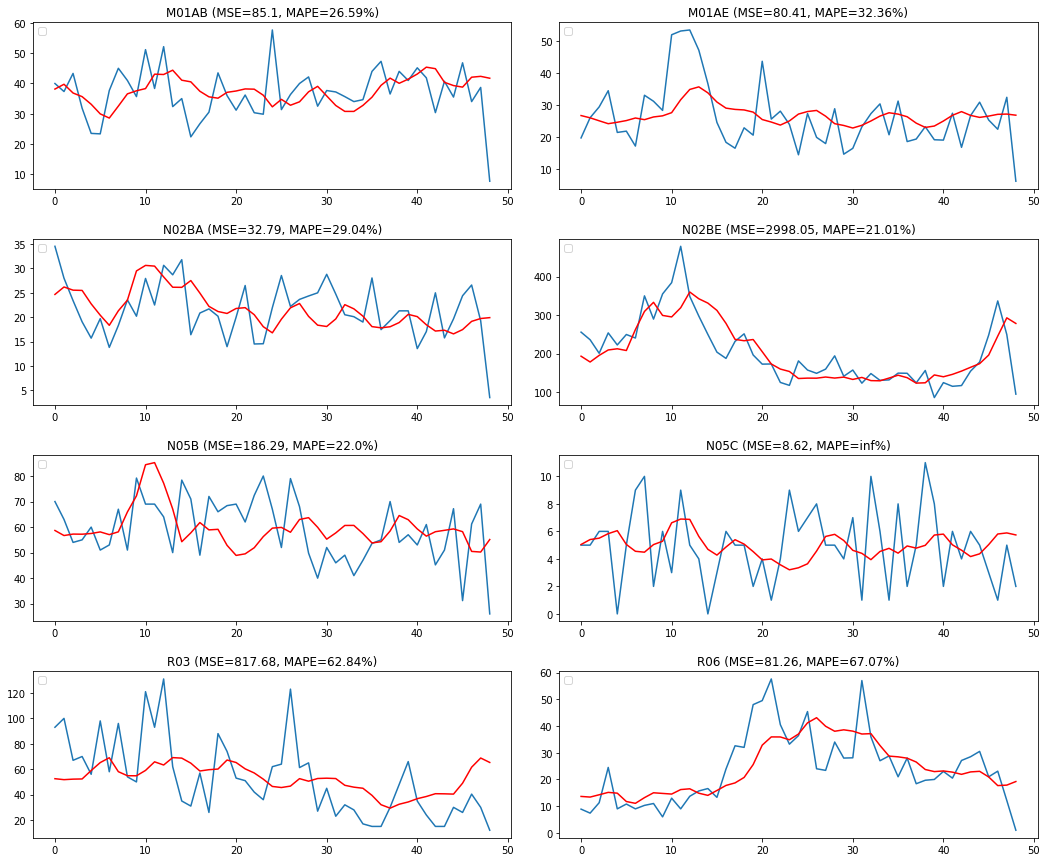

In [ ]:
df=pd.read_csv('/content/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")
M01AB= {'series':'M01AB','params_grid':{'changepoint_prior_scale':30,'interval_width':0.0005}}
M01AE= {'series':'M01AE','params_grid':{'changepoint_prior_scale':0.05,'interval_width':0.0005}}
N02BA= {'series':'N02BA','params_grid':{'changepoint_prior_scale':0.005,'interval_width':0.0005}}
N02BE= {'series':'N02BE','params_grid':{'changepoint_prior_scale':10,'seasonality_prior_scale':170,'interval_width':0.0005}}
N05B= {'series':'N05B','params_grid':{'changepoint_prior_scale':5,'interval_width':0.0005}}
N05C= {'series':'N05C','params_grid':{'changepoint_prior_scale':0.5,'interval_width':0.005}}
R03= {'series':'R03','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':160,'interval_width':0.0005}}
R06= {'series':'R06','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':120,'interval_width':0.0005}}
r=[M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]

for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = len(dfg) - 50
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    history = dfgtrain.copy()
    predictions = list()
    
    for t in dfgtest['ds'].values:
        model = prophet.Prophet(changepoint_prior_scale=x['params_grid']['changepoint_prior_scale'],
                                  growth='linear', 
                                  interval_width=x['params_grid']['interval_width'],  daily_seasonality=False, 
                                  weekly_seasonality=False
                           )
        if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
            model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                prior_scale=x['params_grid']['seasonality_prior_scale'],
                                fourier_order=13)
        model_fit = model.fit(history)
        future = model.make_future_dataframe(periods=1, freq='W')
        output = model.predict(future)
        yhat = output.loc[output.ds==t]['yhat'].values[0]
        predictions.append(yhat)
        obs = dfgtest.loc[dfgtest.ds==t]['y'].values[0]
        dd=pd.DataFrame([[t,obs]],columns=['ds','y'])
        history=history.append(dd)
        
    error = mean_squared_error(dfgtest['y'].values, predictions)
    perror = mean_absolute_percentage_error(dfgtest['y'].values, predictions)
    resultsRollingdf.loc['Prophet MSE',x['series']]=error
    resultsRollingdf.loc['Prophet MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(dfgtest['y'].values)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

In [ ]:
df=pd.read_csv('/content/salesweekly.csv')

M01AB= {
    'series':'M01AB',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[10,30,50],
               'interval_width':[0.0005]
              }
}
M01AE= {
    'series':'M01AE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],
               'interval_width':[0.0005]
              }
}
N02BA= {
    'series':'N02BA',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.005,0.01,0.05,0.1],
                   'interval_width':[0.0005]
              }
}
N02BE= {
    'series':'N02BE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[5,10,50],'seasonality_prior_scale':[150,170,200],
               'interval_width':[0.0005]
              }
}
N05B= {
    'series':'N05B',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[1,5,10],
               'interval_width':[0.0005]
              }
}
N05C= {
    'series':'N05C',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.05,0.08,0.1,0.5],
               'interval_width':[0.0005]
              }
}
R03= {
    'series':'R03',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[120,160,200],
               'interval_width':[0.0005]
              }
}
R06= {
    'series':'R06',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[100,120,160,200],
               'interval_width':[0.0005]
              }
}
r=[M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]
warnings.filterwarnings("ignore")

for x in r:
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = int(len(dfg) - 50)
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    predictions = list()
    minError=0
    grid = ParameterGrid(x['params_grid'])
    for p in grid:
        model = prophet.Prophet(**p, daily_seasonality=False, weekly_seasonality=False)
        if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
            model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                fourier_order=13)
        model_fit = model.fit(dfgtrain)
        future = model.make_future_dataframe(periods=50, freq='W')
        output = model.predict(future)
        predictions=output.loc[size+2:len(dfg),:]['yhat'].values
        error = mean_squared_error(dfgtest['y'].values, predictions)
        if(minError>0):
            if(error<minError):
                minError=error
                minP=p
        else:
          minError=error
          minP=p

    print(minP)
    print('Test MSE ('+x['series']+'): %.3f' % minError)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/wrkkcqio.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/u5yn9pd9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24212', 'data', 'file=/tmp/tmpd0ewsj7j/wrkkcqio.json', 'init=/tmp/tmpd0ewsj7j/u5yn9pd9.json', 'output', 'file=/tmp/tmpd0ewsj7j/prophet_modelnaq2xs13/prophet_model-20230225094018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/1pgwixhz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/g3s_yow7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 30, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (M01AB): 69.800


DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/a_a6tul5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/6qzffrsm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42636', 'data', 'file=/tmp/tmpd0ewsj7j/a_a6tul5.json', 'init=/tmp/tmpd0ewsj7j/6qzffrsm.json', 'output', 'file=/tmp/tmpd0ewsj7j/prophet_modelle142t7v/prophet_model-20230225094019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/qd8_68ya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/0ttw9cem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (M01AE): 79.585


DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/z5c96nfl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/cfk6bdcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33002', 'data', 'file=/tmp/tmpd0ewsj7j/z5c96nfl.json', 'init=/tmp/tmpd0ewsj7j/cfk6bdcu.json', 'output', 'file=/tmp/tmpd0ewsj7j/prophet_modelcdbtu6cm/prophet_model-20230225094020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/w8e4xnbx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/c60whfbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N02BA): 32.258


09:40:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/ar1taxgd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/1tw5z6_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28886', 'data', 'file=/tmp/tmpd0ewsj7j/ar1taxgd.json', 'init=/tmp/tmpd0ewsj7j/1tw5z6_a.json', 'output', 'file=/tmp/tmpd0ewsj7j/prophet_modelf1t0p00l/prophet_model-20230225094022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly

{'changepoint_prior_scale': 10, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 150}
Test MSE (N02BE): 3075.780


DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/8unx0epi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/lnia5xdr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40441', 'data', 'file=/tmp/tmpd0ewsj7j/8unx0epi.json', 'init=/tmp/tmpd0ewsj7j/lnia5xdr.json', 'output', 'file=/tmp/tmpd0ewsj7j/prophet_modelr3d5n44f/prophet_model-20230225094026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/szc9_0b8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/esoxd4cg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 5, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N05B): 302.904


DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/vvkdds19.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/35vd9yd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84114', 'data', 'file=/tmp/tmpd0ewsj7j/vvkdds19.json', 'init=/tmp/tmpd0ewsj7j/35vd9yd8.json', 'output', 'file=/tmp/tmpd0ewsj7j/prophet_model4oqrpy4f/prophet_model-20230225094027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/nuyv6h7_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/gp8ter52.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N05C): 8.373


09:40:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/k_u9bh7k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/06aaf_ul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16620', 'data', 'file=/tmp/tmpd0ewsj7j/k_u9bh7k.json', 'init=/tmp/tmpd0ewsj7j/06aaf_ul.json', 'output', 'file=/tmp/tmpd0ewsj7j/prophet_modelt6nyqmdy/prophet_model-20230225094029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly

{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 160}
Test MSE (R03): 837.152


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/mrutr90i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/mwkgjnzh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5689', 'data', 'file=/tmp/tmpd0ewsj7j/mrutr90i.json', 'init=/tmp/tmpd0ewsj7j/mwkgjnzh.json', 'output', 'file=/tmp/tmpd0ewsj7j/prophet_modelbekyn2xo/prophet_model-20230225094033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd0ewsj7j/lh2wh

{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 120}
Test MSE (R06): 76.725


In [ ]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

size = int(len(df) - 50)
n_steps=5
n_features = 1

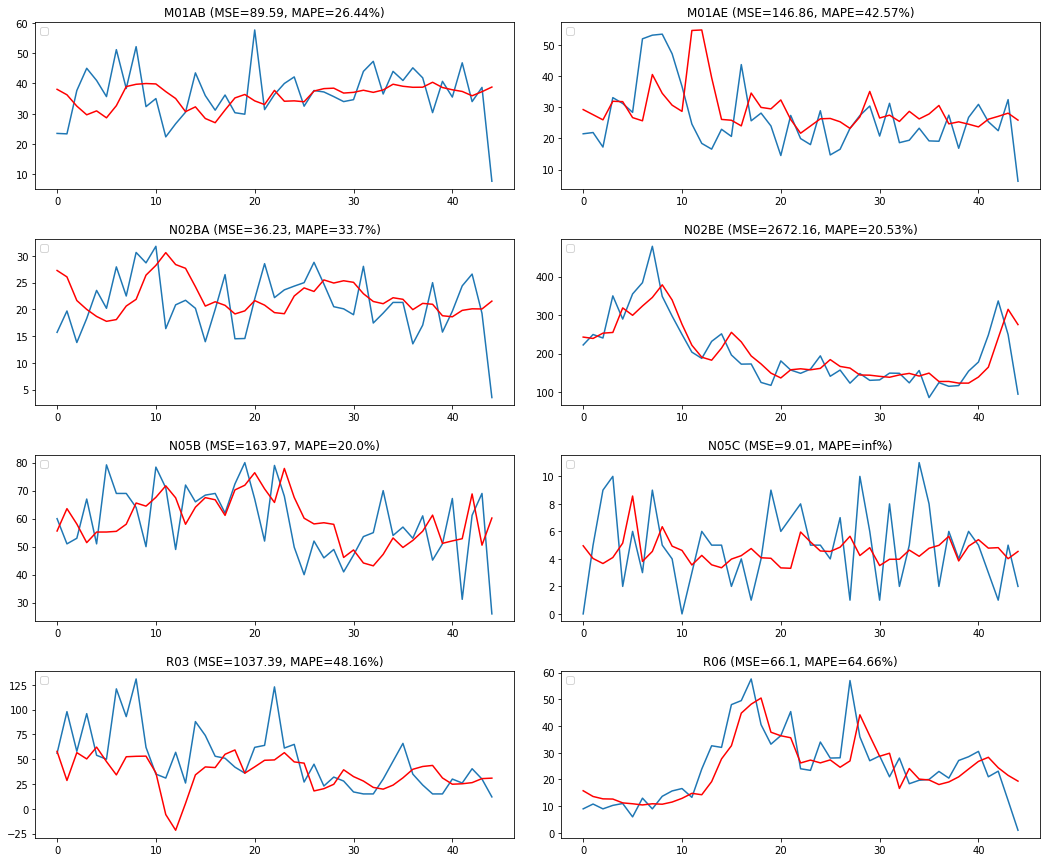

In [ ]:
df=pd.read_csv('/content/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)

    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Bidirectional LSTM MSE',x]=error
    resultsLongtermdf.loc['Bidirectional LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

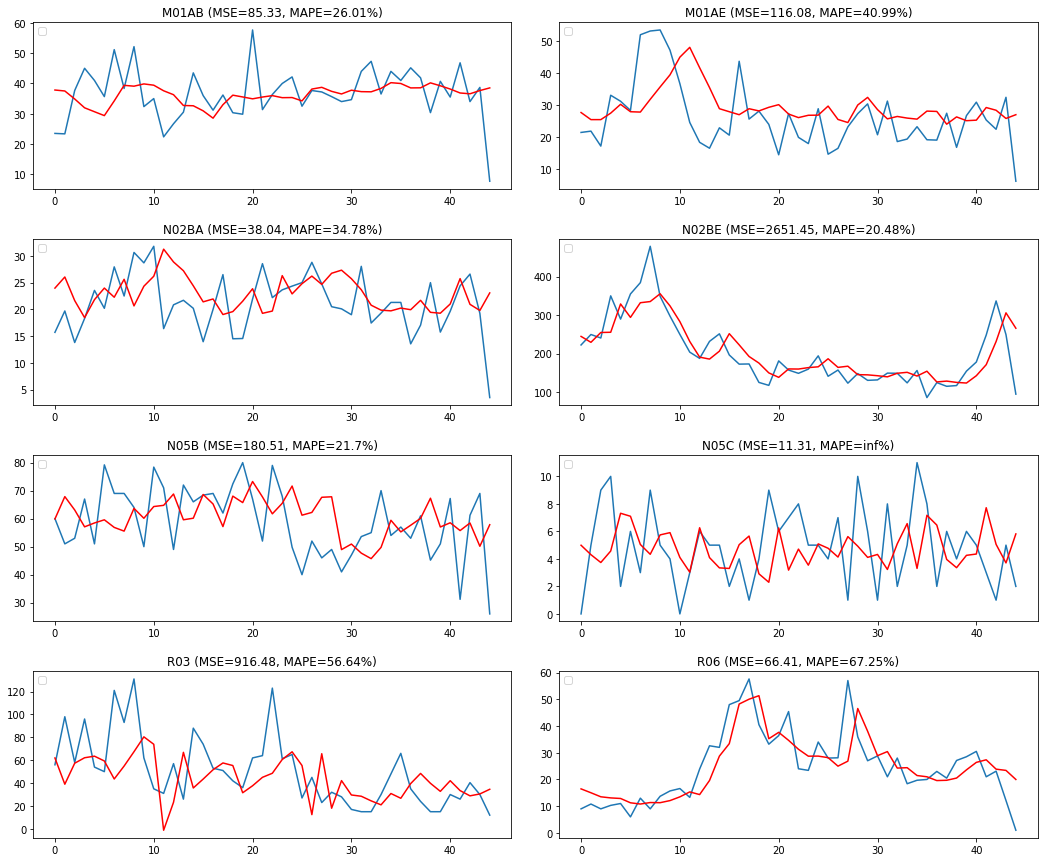

In [ ]:
df=pd.read_csv('/content/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)
    
    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Stacked LSTM MSE',x]=error
    resultsLongtermdf.loc['Stacked LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

In [ ]:
from IPython.display import display, HTML
display(HTML(resultsRollingdf.to_html()))

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
Naive MSE,116.014866,93.875126,44.741150,2753.643864,255.485600,14.920000,948.560347,82.228700
Naive MAPE,28.765667,36.202952,33.475848,21.451644,24.308687,inf,47.432638,52.094536
Seasonal Naive MSE,0.000000,0.000000,0.000000,2923.370345,0.000000,0.000000,1141.258975,87.288057
Seasonal Naive MAPE,0.000000,0.000000,0.000000,19.976880,0.000000,0.000000,48.845563,52.491895
ARIMA MSE,74.768467,76.572677,31.898614,2615.907144,151.372279,7.949817,685.617134,75.038188
ARIMA MAPE,22.730366,32.989440,29.131300,20.524169,19.063637,inf,50.709673,60.593717
AutoARIMA MSE,76.873387,76.568961,0.000000,0.000000,147.113406,0.000000,0.000000,0.000000
AutoARIMA MAPE,23.951630,32.989525,0.000000,0.000000,18.864135,0.000000,0.000000,0.000000
Prophet MSE,85.097085,80.406812,32.790127,2998.047991,186.290548,8.622748,817.678668,81.257744
Prophet MAPE,26.594905,32.358770,29.037780,21.011428,22.000206,inf,62.844157,67.074629
